En este archivo notebook implementaremos el método TIRM, guardando la salida en un archivo pickle. Este será el archivo que enviemos al servidor.

In [2]:
#Cargamos los paquetes necesarios.

import pickle
import bson
import pandas as pd
from bson import ObjectId

In [3]:
#Cargamos tanto los usuarios como todas las interacciones.

filename = "usuarios.pickle"
usuarios = pd.read_pickle(filename)
#Guardamos todos los ids de los usuarios de la muestra para limpiar las interacciones
idsMuestra = usuarios["_id"].to_list()

#Cargamos los datos de los tweets.
filename = "tweets.pickle"
tweets = pd.read_pickle(filename)

#Solo nos quedamos con las interacciones que se hayan realizado entre un par de 
#usuarios cuyos ids hayamos cogido antes.
tweets = tweets[tweets.user_id.isin(idsMuestra)
                & (tweets.in_reply_to_user_id.isin(idsMuestra) | 
                tweets.retweet_or_quote_user_id.isin(idsMuestra))]

In [4]:
#Unimos las columnas del conjuto de datos tweets referentes al usuario al que va dirigida la interacción,
#ya que este dato está dividido en dos columnas dependiendo del tipo de interacción.

to_user_id = []

for index, row in tweets.iterrows():
    if row["in_reply_to_user_id"] == None:
        
        to_user_id.append(row["retweet_or_quote_user_id"])
        
    else:
        
        to_user_id.append(row["in_reply_to_user_id"])
        
tweets["to_user_id"] = to_user_id

#Tras esto realizamos el group by

prueba = tweets.groupby(['user_id', 'to_user_id', 'tweet_type'])['to_user_id'].count().reset_index(name="count")

In [5]:
#Una vez agrupados los datos referentes a las interacciones, vamos a descartar del conjunto de usuarios todos 
#aquellos que no realizen ni reciban ninguna interacción.

aliveUsers = []

for index, row in prueba.iterrows():
    
    if (row['user_id'] in aliveUsers) == False:
        
        aliveUsers.append(row['user_id'])
        
    if (row['to_user_id'] in aliveUsers) == False:
        
        aliveUsers.append(row['to_user_id'])

    
    
usuarios = usuarios[usuarios._id.isin(aliveUsers)]

#Machacamos el conjunto de ids de la muestra de usuarios

idsMuestra = usuarios["_id"].to_list()

In [31]:
#Claramente la cantidad de usuarios que estamos estudiando se ve reducida drsticamente cuando eliminamos los 
#que no han realizado ni una interaccion, pero ademas este conjunto deberia reducirse aun mas ya que seguimos
#usando un monton de usuarios que solo producen tweets pero nadie se dirige a ellos.
len(usuarios)

68012

In [6]:
#Creamos un diccionario que relaciona todos los usuarios con todos los usuarios que alguna vez han creado contenido
#refiriendose a este, y asocia el número de cada tipo que ha realizado.
interacciones = {}

for index, row in prueba.iterrows():
    
    #Si son de tipo originales no los tenemos en cuenta.
    if row["tweet_type"] != "original":
    
        #Comprobamos si para este usuario hemos creado ya su hueco en el diccionario, si no se crea.
        if row["to_user_id"] in interacciones:
        
            if row["user_id"] in interacciones[row["to_user_id"]]:
                
                interacciones[row["to_user_id"]][row["user_id"]][row["tweet_type"]] = row["count"]
        
            else:
                
                interacciones[row["to_user_id"]][row["user_id"]] = {"quote" : 0, "retweet" : 0, "reply" : 0}
                
                interacciones[row["to_user_id"]][row["user_id"]][row["tweet_type"]] = row["count"]
                
        
        else:
        
            interacciones[row["to_user_id"]] = {}
            
            interacciones[row["to_user_id"]][row["user_id"]] = {"quote" : 0, "retweet" : 0, "reply" : 0}
                
            interacciones[row["to_user_id"]][row["user_id"]][row["tweet_type"]] = row["count"]

In [7]:
#Ahora vamos a quedarnos con los conjuntos de seguidores de cada usuario pero de forma que todos los usuarios con los
#que nos quedemos también estén en la red ya que si no, no nos proporciona nada. Para ello definimos una función que
#realiza la intersección de dos conjuntos

def intersectionLists(list1, list2):  

    result = list(set(list1).intersection(list2))
    return result

followers = {}

for index, row in usuarios.iterrows():
    
    followers[row["_id"]] = intersectionLists(idsMuestra, row["followers"])
    
idNodos = idsMuestra

In [8]:
#Ahora vamos a crear las aristas de cada grafo, para ello definimos un diccionario que contendra todas las aristas
#como clave, y el peso de cada una de ellas como valor.

#GRAFO DE FOCO

aristasGF = {}
beta = 0.7

for user1 in interacciones:
    
    for user2 in interacciones[user1]:
        
        if (interacciones[user1][user2]["reply"] > 0 or interacciones[user1][user2]["retweet"] > 0):
            if user1 != user2:
                arista = "("+str(user1)+","+str(user2)+")"
                aristasGF[arista] = beta *  interacciones[user1][user2]["retweet"] + (1-beta) * interacciones[user1][user2]["reply"]
            
            
#GRAFO DE AUTORIDAD

aristasGA = {}

for user1 in interacciones:
    
    for user2 in interacciones[user1]:
        
        if (interacciones[user1][user2]["quote"] > 0) and user1 != user2:
            
            arista = "("+str(user1)+","+str(user2)+")"
            aristasGA[arista] = interacciones[user1][user2]["quote"]
            
            
#GRAFO DE CENTRALIDAD

aristasGC = {}
gamma = 0.6

for user1 in followers:
    
    for user2 in followers[user1]:
        arista = "("+str(user1)+","+str(user2)+")"
        aristasGC[arista] = gamma * len(followers[user1]) + (1 - gamma) * len(followers[user2])

In [ ]:
#Vamos a guardar los diferentes diccionarios que representan las aristas de cada grafo, junto a la lista de 
#todos los nodos.

import pickle

f = open("aristasGF.pkl","wb")
pickle.dump(aristasGF,f)
f.close()

f = open("aristasGA.pkl","wb")
pickle.dump(aristasGA,f)
f.close()

f = open("aristasGC.pkl","wb")
pickle.dump(aristasGC,f)
f.close()

f = open("idNodos.pkl","wb")
pickle.dump(idNodos,f)
f.close()

In [9]:
#Una vez llegados a este punto, tenemos todos los pesos de aristas para cada uno de los grafos, luego podemos 
#comenzar a calcular los pesos para cada nodo en cada grafo. 

#Vamos a realizar un paso previo y muy importante, este es relacionar cada nodo con sus aristas para cada grafo
#Cada nodo con las aristas que salen de el. De esta forma evitamos repetir el proceso muchas veces. 
#Las claves son los ids de los usuarios pero en string.

def nodoAristas(aristasGrafo):
    
    nodoAristas = {}
    for nodoId in idNodos:
        
        nodoid = str(nodoId)
        nodoAristas[nodoid] = []
        for arista in aristasGrafo:
            
            if ("("+nodoid) in arista:
                
                nodoAristas[nodoid].append(arista)
                
    return nodoAristas

nodoAristasGF = nodoAristas(aristasGF)
nodoAristasGA = nodoAristas(aristasGA)
nodoAristasGC = nodoAristas(aristasGC)

#Pasamos ahora al cálculo del peso NIWT:
#No necesitamos introducir nodos a la función ya que los tres grafos trabajan con el mismo conjunto.
def NIWT(aristasGrafo, alpha, nodoA): 
    
    NIWT = {}
    for nodoId in idNodos:
        
        nodoid = str(nodoId)
        pesosAristas = 0
        
        for key in nodoA[nodoid]:
            
            pesosAristas = pesosAristas + aristasGrafo[key]
        
        NIWT[nodoid] = alpha * len(nodoA[nodoid]) + (1 - alpha) * pesosAristas

    return NIWT


NIWTfoco = NIWT(aristasGF, 0.5, nodoAristasGF)
NIWTautoridad = NIWT(aristasGA, 0.5, nodoAristasGA)
NIWTcentralidad = NIWT(aristasGC, 0.5, nodoAristasGC)

In [10]:
#Ahora pasamos al cálculo de los pesos en la fase de poda del grafo, NPWT.

def NPWT(aristasGrafo, alpha, niwt, nodoA):
    
    NPWT = {}
    for nodo1 in idNodos:
        
        nodo1id = str(nodo1)
        pesoGrafo = 0
        
        for nodo2 in idNodos:
            
            pesosAristas = 0
            nodo2id = str(nodo2)
            
            if nodo2 != nodo1:
                
                for arista in nodoA[nodo2id]:
                    
                    nodo3id = ((arista.split(","))[1])[:-1]
                    
                    pesosAristas = pesosAristas + aristasGrafo[arista] + niwt[nodo3id]
                
                pesoGrafo = pesoGrafo + alpha * len(nodoA[nodo2id]) + (1 - alpha) * pesosAristas
        
        NPWT[nodo1id] = pesoGrafo
    
    return NPWT 

NPWTfoco = NPWT(aristasGF, 0.5, NIWTfoco, nodoAristasGF)
NPWTautoridad = NPWT(aristasGA, 0.5, NIWTautoridad, nodoAristasGA)
NPWTcentralidad = NPWT(aristasGC, 0.5, NIWTcentralidad, nodoAristasGC)

In [19]:
#También guardamos estos datos de cada grafo por si los necesitaramos más adelante.

f = open("NPWTfoco.pkl","wb")
pickle.dump(NPWTfoco,f)
f.close()

f = open("NPWTautoridad.pkl","wb")
pickle.dump(NPWTautoridad,f)
f.close()

f = open("NPWTcentralidad.pkl","wb")
pickle.dump(NPWTcentralidad,f)
f.close()

In [11]:
#Una vez tenemos los resultados de cada nodo, los ordenamos en capas

def capas(NPWT):
    
    capas = {}
    
    for nodo in NPWT:
        
        if (NPWT[nodo] in capas):
            
            capas[NPWT[nodo]].append(nodo)
            
        else:
            
            capas[NPWT[nodo]] = [nodo]
            
    return capas

capasFoco = capas(NPWTfoco)
capasAutoridad = capas(NPWTautoridad)
capasCentralidad = capas(NPWTcentralidad)

#Guardamos la cantidad de capas de cada una de las listas para poder cálcular nuestra medida

ncf = len(capasFoco)
nca = len(capasAutoridad)
ncc = len(capasCentralidad)

In [12]:
#Faltaría ordenar el diccionario por el valor de sus key, y luego cambiar el nombre de las key por 1,2,3..
#lo que serían las capas respectivas. DESCENDENTE


#Para el grafo de foco
puntuaciones = list(capasFoco.keys())
puntuaciones.sort(reverse = True)

capasFocoOrd = {}
contador = 0

for key in puntuaciones:
    
    capasFocoOrd[contador] = capasFoco[key]
    contador = contador + 1

    
    
    
#Para el grafo de autoridad
puntuaciones = list(capasAutoridad.keys())
puntuaciones.sort(reverse = True)

capasAutoridadOrd = {}
contador = 0

for key in puntuaciones:
    
    capasAutoridadOrd[contador] = capasAutoridad[key]
    contador = contador + 1

    
    
    
#Para el grafo de centralidad
puntuaciones = list(capasCentralidad.keys())
puntuaciones.sort(reverse = True)

capasCentralidadOrd = {}
contador = 0

for key in puntuaciones:
    
    capasCentralidadOrd[contador] = capasCentralidad[key]
    contador = contador + 1

In [13]:
def userCapa(capasOrd):
    
    userCapa = {}
    
    for capa in capasOrd:
        for user in capasOrd[capa]:
            
            userCapa[user] = capa
    
    return userCapa

userCapaFoco = userCapa(capasFocoOrd)
userCapaAutoridad = userCapa(capasAutoridadOrd)
userCapaCentralidad = userCapa(capasCentralidadOrd)

In [116]:
ncf

1387

In [111]:
userCapaFoco['000000000000000107153756']

1382

In [117]:
ncc

24181

In [112]:
userCapaCentralidad['000000000000000107153756']

24180

In [118]:
nca

28

In [113]:
userCapaAutoridad['000000000000000107153756']

20

In [14]:
#Calculamos la medida con la siguiente función 

import math

def TI(userCapa1, userCapa2, userCapa3, nc1, nc2, nc3):
    
    TI = {}
    
    numberUsers = len(userCapa1)
    digitos = len(str(numberUsers))
    h1 = digitos/2
    h = round(digitos/2)
    if h1 > h:
        h + 1
        
    for user in userCapa1:
        if (userCapa1[user] + userCapa2[user] + userCapa3[user]) != 0:
            TI[user] = ( (math.log(userCapa1[user] + userCapa2[user] + userCapa3[user])) / math.log(nc1 + nc2 + nc3) )**(h)
        else:
            TI[user] = 0
    
    return TI
    

TIFinal = TI(userCapaFoco, userCapaAutoridad, userCapaCentralidad, ncf, nca, ncc)

In [30]:
len(TIFinal)

68012

In [40]:
#Finalmente, con las puntuaciones conseguidas vamos a ordenarlos otra vez, lo que ya será la puntuación final.
TIFGrupos = {}

for user in TIFinal:
    
    if TIFinal[user] in TIFGrupos:
        TIFGrupos[TIFinal[user]].append(user)
    else:
        TIFGrupos[TIFinal[user]] = [user]

puntuaciones = list(TIFGrupos.keys())
puntuaciones.sort(reverse = True)

puntuacionesOrd = {}

for key in puntuaciones:
    
    puntuacionesOrd[key] = TIFGrupos[key]

In [41]:
#Vamos a comprobar la separación realizada mediante el Average Shell Load ASL
ALS = 0
for capa in puntuacionesOrd:
    
    ALS = ALS + len(puntuacionesOrd[capa])
    
ALS = ALS/len(puntuacionesOrd)
ALS

3.1878134520740566

In [110]:
puntuacionesOrd

{0.9998921999920694: ['000000000000000107153756'],
 0.9998305761074858: ['000000000000001361984828'],
 0.9997997576482794: ['000000000000000202372417'],
 0.9997612284621038: ['000000933309177623121921'],
 0.9996841497063162: ['000000000000000125407623'],
 0.9996070437558533: ['000000000000000301403189'],
 0.999560767123758: ['000000000000000121385551'],
 0.9995453394017891: ['000000000000003346916993'],
 0.9995067653311034: ['000000000000000200194757'],
 0.9994681844501645: ['000000000000000018097083'],
 0.9994295967564512: ['000000000000000015133318'],
 0.9994218783999532: ['000000000000000402219133'],
 0.9994064408690414: ['000000000000000280148714'],
 0.9993987216945865: ['000000000000000149064381'],
 0.9993832825275788: ['000000000000000040900410'],
 0.9993524009206036: ['000000000000002809058993'],
 0.9993446798368752: ['000000000000002299875572'],
 0.9993292368508963: ['000000000000000331008858'],
 0.9992674539903738: ['000000000000000093929450'],
 0.9992442809131313: ['000000000

In [69]:
#Que se obtenga finalmente esa puntuacion me hace darme cuenta de que siguen habiendo miles de usuarios
#que no reciben ningun tipo de interaccion, solo la producen ellos.

len(puntuacionesOrd)

21335

In [43]:
len(puntuacionesOrd[0])

13778

In [17]:
#Guardamos el resultado final que nos ordena todos los nodos según su puntuación final.

f = open("puntuacionesOrd.pkl","wb")
pickle.dump(puntuacionesOrd,f)
f.close()

In [102]:
veinPrim = []
veinTerc = []
veinQuin = []

for puntuacion in puntuacionesOrd:
        
    for user in puntuacionesOrd[puntuacion]:
        
        if len(veinPrim) < 20:
            
            veinPrim.append(user)
            
          
        elif len(veinTerc) < 20:
            
            veinTerc.append(user)
        
        elif len(veinQuin) < 20:
            
            veinQuin.append(user)
        
        else:
            
            break

In [119]:
veinPrim = []
veinTerc = []
veinQuin = []

for puntuacion in puntuacionesOrd:
        
    for user in puntuacionesOrd[puntuacion]:
        
        if len(veinPrim) < 20:
            
            veinPrim.append(user)
            
          
        elif len(veinTerc) < 20:
                
            veinTerc.append(user)
            
        else:
            if len(veinQuin) == 20:
                break
                
            veinQuin.append(user)

In [86]:
#Una vez tenemos todas las soluciones ordenadas en cuanto a la puntuación en la medida, vamos a estudiar las 
#soluciones.

#Vamos a tomar los primeros 20 usuarios en el top, 20 usuarios a mitad de ranking y los 20 últimos y con estos ids
#vamos a estudiar las características que los diferencian.

#Debido a que los 20 de la mitad y los 20 del final (estos mas aun), no tienen interacciones, vamos a seleccionar
#los grupos 10(primeros), 8 y 6 de entre los que surgirian al dividirlos en 10 grupos los usuarios ordenados.


#Veinte primeros
veinPrim = []
veinTerc = []

for puntuacion in puntuacionesOrd:
        
    for user in puntuacionesOrd[puntuacion]:
        
        if len(veinPrim) < 20:
            
            veinPrim.append(user)
            
          
        elif len(veinTerc):
            
            break

    
#Dividimos todas las puntuaciones ordenados en 10 grupos de un mismo tamannno
entrediez = round(len(puntuacionesOrd)/200)
    
    
#Veinte del tercergrupo
veinTerc = []


terc = 198 * entrediez
contador = 0 

for puntuacion in puntuacionesOrd:
    
    contador = contador + 1
    
    if contador >= terc:
        
        for user in puntuacionesOrd[puntuacion]:
            
            if len(veinTerc) == 20:
                
                break
                
            veinTerc.append(user)
        
    
#Veinte del quinto grupo
veinQuin = []

quin = 196 * entrediez
contador = 0 

for puntuacion in puntuacionesOrd:
    
    contador = contador + 1
    
    if contador >= quin:
        
        for user in puntuacionesOrd[puntuacion]:
            
            if len(veinQuin) == 20:
                
                break
                
            veinQuin.append(user)

In [103]:
len(veinQuin)

20

In [120]:
#Ya disponemos de los 60 usuarios que vamos a comparar.

#Para comparar sus posiciones dentro de los diferentes nodos de la red vamos a representar los 3 con gephi.


#Debemos comparar también el resto de datos. Vamos a guardar para cada usuario todos los datos totales 
#que componen sus perfiles.

veinprim = {}
veinterc = {}
veinquin = {}


#Cargamos los datos que vamos a utilizar

#filename = "interacciones.pkl"
#interacciones = pd.read_pickle(filename)
#filename = "followers.pkl"
#followers = pd.read_pickle(filename)

for user in veinPrim:
    
    veinprim[user] = {"followers":0, "quotes":0, "retweets":0, "replies":0}
    
    veinprim[user]["followers"] = len(followers[ObjectId(user)])
    
    if ObjectId(user) in interacciones:
        for u in interacciones[ObjectId(user)]:
        
            veinprim[user]["quotes"] = veinprim[user]["quotes"] + interacciones[ObjectId(user)][u]["quote"]
            veinprim[user]["retweets"] = veinprim[user]["retweets"] + interacciones[ObjectId(user)][u]["retweet"]
            veinprim[user]["replies"] = veinprim[user]["replies"] + interacciones[ObjectId(user)][u]["reply"]
        

for user in veinTerc:
    
    veinterc[user] = {"followers":0, "quotes":0, "retweets":0, "replies":0}
    
    veinterc[user]["followers"] = len(followers[ObjectId(user)])
    
    if ObjectId(user) in interacciones:
        for u in interacciones[ObjectId(user)]:
        
            veinterc[user]["quotes"] = veinterc[user]["quotes"] + interacciones[ObjectId(user)][u]["quote"]
            veinterc[user]["retweets"] = veinterc[user]["retweets"] + interacciones[ObjectId(user)][u]["retweet"]
            veinterc[user]["replies"] = veinterc[user]["replies"] + interacciones[ObjectId(user)][u]["reply"]
    
for user in veinQuin:
    
    veinquin[user] = {"followers":0, "quotes":0, "retweets":0, "replies":0}
    
    veinquin[user]["followers"] = len(followers[ObjectId(user)])
    
    if ObjectId(user) in interacciones:
        for u in interacciones[ObjectId(user)]:
        
            veinquin[user]["quotes"] = veinquin[user]["quotes"] + interacciones[ObjectId(user)][u]["quote"]
            veinquin[user]["retweets"] = veinquin[user]["retweets"] + interacciones[ObjectId(user)][u]["retweet"]
            veinquin[user]["replies"] = veinquin[user]["replies"] + interacciones[ObjectId(user)][u]["reply"]

In [121]:
#Necesitamos tener los datos sobre los que vamos a hacer plot dentro de listas para que así funcione el código

veinprim_followers = []
veinprim_quotes = []
veinprim_replies = []
veinprim_retweets = []
for user in veinprim:
    veinprim_followers.append(veinprim[user]['followers'])
    veinprim_quotes.append(veinprim[user]['quotes'])
    veinprim_replies.append(veinprim[user]['replies'])
    veinprim_retweets.append(veinprim[user]['retweets'])
    
veinterc_followers = []
veinterc_quotes = []
veinterc_replies = []
veinterc_retweets = []
for user in veinterc:
    veinterc_followers.append(veinterc[user]['followers'])
    veinterc_quotes.append(veinterc[user]['quotes'])
    veinterc_replies.append(veinterc[user]['replies'])
    veinterc_retweets.append(veinterc[user]['retweets'])
    
veinquin_followers = []
veinquin_quotes = []
veinquin_replies = []
veinquin_retweets = []
for user in veinquin:
    veinquin_followers.append(veinquin[user]['followers'])
    veinquin_quotes.append(veinquin[user]['quotes'])
    veinquin_replies.append(veinquin[user]['replies'])
    veinquin_retweets.append(veinquin[user]['retweets'])

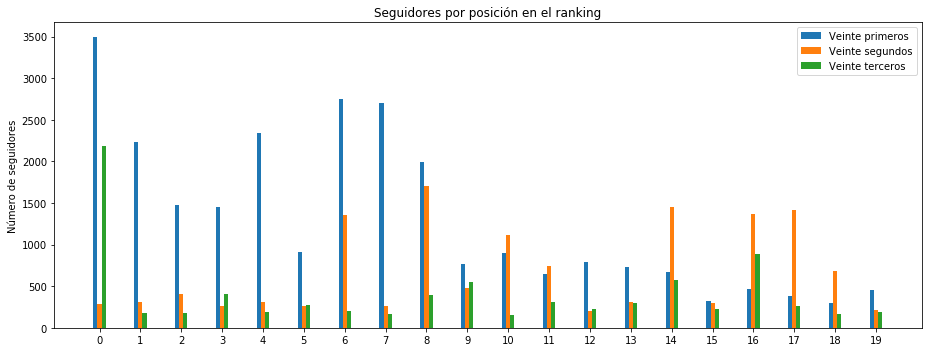

In [158]:
#Pasamos a hacer los plots con todos los datos disponibles.

#Primero con respecto al valor del número de seguidores.

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

def autolabel(rects, xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0, 'right': 1, 'left': -1}

    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(offset[xpos]*3, 3),  # use 3 points offset
                    textcoords="offset points",  # in both directions
                    ha=ha[xpos], va='bottom')

ind = np.arange(len(veinprim_followers))  # the x locations for the groups
width = 0.1  # the width of the bars

fig, ax = plt.subplots(figsize=(13,5))
rects1 = ax.bar(ind - width, veinprim_followers, width,
                label='Veinte primeros')
rects2 = ax.bar(ind, veinterc_followers, width,
                label='Veinte segundos')
rects3 = ax.bar(ind + width, veinquin_followers, width,
                label='Veinte terceros')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Número de seguidores')
ax.set_title('Seguidores por posición en el ranking')
ax.set_xticks(ind)
#ax.set_xticklabels(('G1', 'G2', 'G3', 'G4', 'G5'))
ax.legend()

autolabel(rects1, "left")
autolabel(rects2, "center")
autolabel(rects3, "right")

fig.tight_layout()


plt.savefig('seguidores.png')

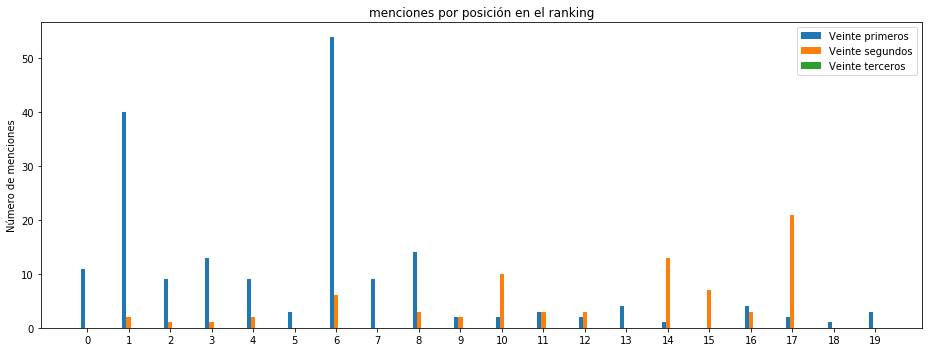

In [159]:
#Ahora comparamos para el número de menciones

def autolabel(rects, xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0, 'right': 1, 'left': -1}

    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(offset[xpos]*3, 3),  # use 3 points offset
                    textcoords="offset points",  # in both directions
                    ha=ha[xpos], va='bottom')

ind = np.arange(len(veinprim_quotes))  # the x locations for the groups
width = 0.1  # the width of the bars

fig, ax = plt.subplots(figsize=(13,5))
rects1 = ax.bar(ind - width, veinprim_quotes, width,
                label='Veinte primeros')
rects2 = ax.bar(ind, veinterc_quotes, width,
                label='Veinte segundos')
rects3 = ax.bar(ind + width, veinfin_quotes, width,
                label='Veinte terceros')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Número de menciones')
ax.set_title('menciones por posición en el ranking')
ax.set_xticks(ind)
#ax.set_xticklabels(('G1', 'G2', 'G3', 'G4', 'G5'))
ax.legend()

autolabel(rects1, "left")
autolabel(rects2, "center")
autolabel(rects3, "right")

fig.tight_layout()

plt.savefig('menciones.png')

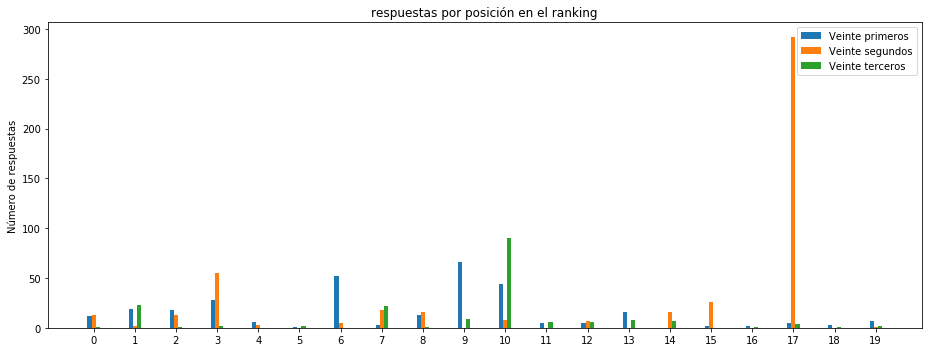

In [160]:
#Número de respuestas a los tweets creados

def autolabel(rects, xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0, 'right': 1, 'left': -1}

    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(offset[xpos]*3, 3),  # use 3 points offset
                    textcoords="offset points",  # in both directions
                    ha=ha[xpos], va='bottom')

ind = np.arange(len(veinprim_replies))  # the x locations for the groups
width = 0.1  # the width of the bars

fig, ax = plt.subplots(figsize=(13,5))
rects1 = ax.bar(ind - width, veinprim_replies, width,
                label='Veinte primeros')
rects2 = ax.bar(ind, veinterc_replies, width,
                label='Veinte segundos')
rects3 = ax.bar(ind + width, veinquin_replies, width,
                label='Veinte terceros')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Número de respuestas')
ax.set_title('respuestas por posición en el ranking')
ax.set_xticks(ind)
#ax.set_xticklabels(('G1', 'G2', 'G3', 'G4', 'G5'))
ax.legend()

autolabel(rects1, "left")
autolabel(rects2, "center")
autolabel(rects3, "right")

fig.tight_layout()

plt.savefig('respuestas.png')

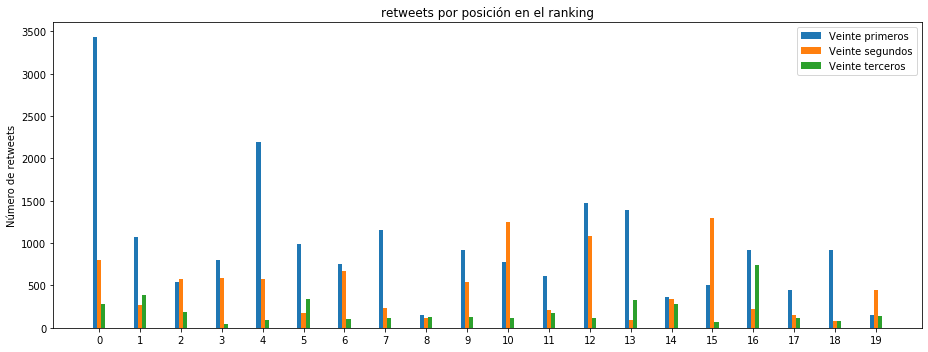

In [161]:
#Número de retweets

def autolabel(rects, xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0, 'right': 1, 'left': -1}

    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(offset[xpos]*3, 3),  # use 3 points offset
                    textcoords="offset points",  # in both directions
                    ha=ha[xpos], va='bottom')

ind = np.arange(len(veinprim_retweets))  # the x locations for the groups
width = 0.1  # the width of the bars

fig, ax = plt.subplots(figsize=(13,5))
rects1 = ax.bar(ind - width, veinprim_retweets, width,
                label='Veinte primeros')
rects2 = ax.bar(ind, veinterc_retweets, width,
                label='Veinte segundos')
rects3 = ax.bar(ind + width, veinquin_retweets, width,
                label='Veinte terceros')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Número de retweets')
ax.set_title('retweets por posición en el ranking')
ax.set_xticks(ind)
#ax.set_xticklabels(('G1', 'G2', 'G3', 'G4', 'G5'))
ax.legend()

autolabel(rects1, "left")
autolabel(rects2, "center")
autolabel(rects3, "right")

fig.tight_layout()

plt.savefig('retweets.png')

In [93]:
#A primera vista la diferencia es bastante palpable entre el top y el centro, supongo que si amplio el dataset
#tendremos unos plot más cómodos.

#Ahora vamos a comprobar si alguno de los usuarios que hemos cogido son bots, tomamos como medida para que sean bots
#0.691, basándonos en el estudio de los tutores. De esta forma vamos a ver que puntuación les hemos aplicado
#y sus diferentes valores en cuanto a sus parámetros.

#Cargamos los datos de los usuarios, y tomamos solo un trozo de los datos para no guardarlo todo.

filename = "usuarios.pickle"
idsProbBot = pd.read_pickle(filename)
#Todos los ids de los usuarios de la muestra

idsProbBot = idsProbBot[["_id", "scores_scores_universal"]]

posBots = {}

for index, row in idsProbBot.iterrows():
    
    if row["scores_scores_universal"] >= 0.691:
        
        posBots[row["_id"]] = row["scores_scores_universal"]
        
for user in posBots:
    if user in TIFinal:
    
        posBots[user]["TI"] = TIFinal[user]

In [ ]:
posBots

In [98]:
#Vamos a crear los archivos csv para introducir dentro del programa gephi

import csv

#Cargamos todos los ids de los usuarios que estamos usando, los relacionamos con sus medidas
#filename = "idNodos.pkl"
#idNodos = pd.read_pickle(filename)

with open("nodes.csv", "w", newline="") as f:
    thewriter = csv.writer(f)
    
    #La primera fila será el nombre de las diferentes columnas.
    thewriter.writerow(["ID", "NPWTfoco", "NPWTautoridad", "NPWTcentralidad", "TI"])
    
    #Para cada nodo guardamos los tres valores de las columnas
    for user in idNodos:
        idstr = str(user)
        thewriter.writerow([idstr, NPWTfoco[idstr], NPWTautoridad[idstr], NPWTcentralidad[idstr], TIFinal[idstr]])

In [99]:
#Vamos a crear ahora el archivo txt referente a las aristas
import csv

with open("edgesFoco.csv", "w", newline="") as f:
    thewriter = csv.writer(f)
    
    #La primera fila será el nombre de las diferentes columnas.
    thewriter.writerow(["Source", "Target", "Type", "Weight"])
    
    #Para cada nodo guardamos los tres valores de las columnas
    for edge in aristasGF:
        e = edge.split(",")
        source = e[0][1:]
        target = e[1][:-1]
        thewriter.writerow([source, target, "Directed", aristasGF[edge]])

In [100]:
with open("edgesAutoridad.csv", "w", newline="") as f:
    thewriter = csv.writer(f)
    
    #La primera fila será el nombre de las diferentes columnas.
    thewriter.writerow(["Source", "Target", "Type", "Weight"])
    
    #Para cada nodo guardamos los tres valores de las columnas
    for edge in aristasGA:
        e = edge.split(",")
        source = e[0][1:]
        target = e[1][:-1]
        thewriter.writerow([source, target, "Directed", aristasGA[edge]])

In [101]:
with open("edgesCentralidad.csv", "w", newline="") as f:
    thewriter = csv.writer(f)
    
    #La primera fila será el nombre de las diferentes columnas.
    thewriter.writerow(["Source", "Target", "Type", "Weight"])
    
    #Para cada nodo guardamos los tres valores de las columnas
    for edge in aristasGC:
        e = edge.split(",")
        source = e[0][1:]
        target = e[1][:-1]
        thewriter.writerow([source, target, "Directed", aristasGC[edge]])

In [126]:
#Estos serian los 20 primeros usuarios encuanto a TIRM
veinPrim

['000000000000000107153756',
 '000000000000001361984828',
 '000000000000000202372417',
 '000000933309177623121921',
 '000000000000000125407623',
 '000000000000000301403189',
 '000000000000000121385551',
 '000000000000003346916993',
 '000000000000000200194757',
 '000000000000000018097083',
 '000000000000000015133318',
 '000000000000000402219133',
 '000000000000000280148714',
 '000000000000000149064381',
 '000000000000000040900410',
 '000000000000002809058993',
 '000000000000002299875572',
 '000000000000000331008858',
 '000000000000000093929450',
 '000000000000000003511961']

In [141]:
userPuestos = {}
contador = 0
for user in veinPrim:
    contador = contador + 1
    userPuestos[user] = {"TIRM":contador, "foco":-userCapaFoco[user]+ncf, "autoridad":-userCapaAutoridad[user]+nca, "centralidad":-userCapaCentralidad[user]+ncc}
    

In [142]:
userPuestos

{'000000000000000107153756': {'TIRM': 1,
  'foco': 5,
  'autoridad': 8,
  'centralidad': 1},
 '000000000000001361984828': {'TIRM': 2,
  'foco': 13,
  'autoridad': 2,
  'centralidad': 7},
 '000000000000000202372417': {'TIRM': 3,
  'foco': 14,
  'autoridad': 10,
  'centralidad': 2},
 '000000933309177623121921': {'TIRM': 4,
  'foco': 18,
  'autoridad': 9,
  'centralidad': 4},
 '000000000000000125407623': {'TIRM': 5,
  'foco': 9,
  'autoridad': 20,
  'centralidad': 12},
 '000000000000000301403189': {'TIRM': 6,
  'foco': 12,
  'autoridad': 22,
  'centralidad': 17},
 '000000000000000121385551': {'TIRM': 7,
  'foco': 22,
  'autoridad': 1,
  'centralidad': 34},
 '000000000000003346916993': {'TIRM': 8,
  'foco': 39,
  'autoridad': 12,
  'centralidad': 8},
 '000000000000000200194757': {'TIRM': 9,
  'foco': 54,
  'autoridad': 5,
  'centralidad': 5},
 '000000000000000018097083': {'TIRM': 10,
  'foco': 26,
  'autoridad': 25,
  'centralidad': 18},
 '000000000000000015133318': {'TIRM': 11,
  'foco': 

In [138]:
userCapaCentralidad

{'000000000000002310170998': 0,
 '000000000000002634362381': 0,
 '000001147586336595087366': 0,
 '000001177936096996610048': 0,
 '000001126469867966742528': 0,
 '000000722496605367201792': 0,
 '000000000000000857896681': 0,
 '000000000000003043731557': 0,
 '000000000000000423518359': 0,
 '000000914863054193610758': 0,
 '000001120789417843744769': 0,
 '000000000000000904599817': 0,
 '000000000000000045734452': 0,
 '000000851480623915184129': 0,
 '000000000000000386053749': 0,
 '000000000000000888683244': 0,
 '000000000000000586832917': 0,
 '000000000000000391389588': 0,
 '000001046142275678597121': 0,
 '000001176758070350962688': 0,
 '000000000000003246121342': 0,
 '000001170825393353441282': 0,
 '000000000000000390173570': 0,
 '000000733736035427987456': 0,
 '000001090017790478741504': 0,
 '000000000000000269727221': 0,
 '000000720712791951347712': 0,
 '000000768099573525086213': 0,
 '000000797459680008269824': 0,
 '000000000000003308528025': 0,
 '000000000000000040093289': 0,
 '000000

In [140]:
#Para el grafo de centralidad
puntuaciones = list(capasCentralidad.keys())
puntuaciones.sort(reverse = False)

capasCentralidadOrd = {}
contador = 0

for key in puntuaciones:
    
    capasCentralidadOrd[contador] = capasCentralidad[key]
    contador = contador + 1
    
capasCentralidadOrd

{0: ['000000000000000107153756'],
 1: ['000000000000000202372417'],
 2: ['000000000000000074205573'],
 3: ['000000933309177623121921'],
 4: ['000000000000000200194757'],
 5: ['000000000000000197863865'],
 6: ['000000000000001361984828'],
 7: ['000000000000003346916993'],
 8: ['000000000000000158313996'],
 9: ['000000000000000064223584'],
 10: ['000000000000000447260411'],
 11: ['000000000000000125407623'],
 12: ['000000000000000040900410'],
 13: ['000000000000000015133318'],
 14: ['000000000000000602263392'],
 15: ['000000000000000402219133'],
 16: ['000000000000000301403189'],
 17: ['000000000000000018097083'],
 18: ['000000000000000331008858'],
 19: ['000000000000000520609496'],
 20: ['000000000000000409256468'],
 21: ['000000000000000222269705'],
 22: ['000000000000000277018118'],
 23: ['000000842106329347039232'],
 24: ['000000000000000003511961'],
 25: ['000000000000000378525757'],
 26: ['000000000000002809058993'],
 27: ['000000000000000022473944'],
 28: ['00000000000000028014871